# part 1: 


In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import glob
from monai import data, transforms
from swincell.utils.data_utils import flow_reshaped



# Configure training parameters

In [13]:
from types import SimpleNamespace
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = SimpleNamespace(
    checkpoint=None,
    amp=False,
    batch_size=1,
    cellpose=True,   #training with image and generated flows
    max_epochs=5,
    optim_lr=1e-5,
    model='swin',
    num_workers=8,
    optimizer='adam',
    resume=None,
    save_temp_img=False,
    seed=0,
    test_mode=False,
    downsample_factor =3, # downsample the input image if it is too large
    # threshold=0.5,
    weight_decay=0.0001,
    # ROI=(64, 64, 32), 
    ROI=(128, 128, 32), 
    workers=8
)



In [14]:
# data folder
data_dir = '/data/download_data/colon_dataset/colon_30/'
img_full_paths = sorted(glob.glob(os.path.join(data_dir,'images/*')))
label_full_paths = sorted(glob.glob(os.path.join(data_dir,'masks_with_flows/*.tiff')))

N = len(os.listdir(os.path.join(data_dir,'images')))
print('number of images:',N)




number of images: 30


In [15]:
# data split

if len(img_full_paths)<5:
    img_full_paths = img_full_paths * 10
    label_full_paths = label_full_paths * 10
valid_img_full_paths = img_full_paths[::5]
valid_label_full_paths = label_full_paths[::5]

train_img_full_paths = [f for i,f in enumerate(img_full_paths) if i%5 != 0]
train_label_full_paths = [f for i,f in enumerate(label_full_paths) if i%5 != 0]

train_datalist = [{'image':image,'label':label} for image,label in zip(train_img_full_paths,train_label_full_paths)]    
val_datalist = [{'image':image,'label':label} for image,label in zip(valid_img_full_paths,valid_label_full_paths)]  


print(len(train_datalist),len(val_datalist))
# img_shape = (129, 1030, 1300)
# img_shape = (512, 512,96)# nanolive XYZ
img_shape = (1300, 1030, 129) # colon 
img_reshape = (img_shape[0]//args.downsample_factor,img_shape[1]//args.downsample_factor,img_shape[2]//args.downsample_factor)
img_reshape = tuple(int(e) for e in img_reshape)
train_transform = transforms.Compose(
    [
        # transforms.LoadImaged(keys=["image", "label"]),
        transforms.LoadImaged(keys=["image", "label"],ensure_channel_first=True),
        flow_reshaped(keys=["label"]),
        transforms.Resized(keys=["image", "label"],spatial_size=img_reshape),

        # transforms.ScaleIntensityRanged(
        #     keys=["image"], a_min=19000, a_max=31000, b_min=0, b_max=1, clip=True
        # ),
        transforms.RandSpatialCropSamplesd(
            keys=["image","label"],
            roi_size=[args.ROI[0],args.ROI[1],args.ROI[2]],

            num_samples=1,
            random_center=True,
            random_size=False,
        ),

        transforms.ToTensord(keys=["image", "label"]),
    ]
)
valid_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.Resized(keys=["image", "label"],spatial_size=(512,512,96)),
        transforms.ScaleIntensityRanged(
            keys=["image"], a_min=21000, a_max=31000, b_min=0, b_max=1, clip=True
            # keys=["image"], a_min=300, a_max=400, b_min=0, b_max=1, clip=True
        ),
        transforms.ToTensord(keys=["image", "label"]),
    ]
)

train_ds = data.Dataset(data=train_datalist, transform=train_transform)
train_loader = data.DataLoader(
        train_ds, batch_size=1, num_workers=8, sampler=None, drop_last=True
    )
valid_ds = data.Dataset(data=val_datalist, transform=valid_transform)
valid_loader = data.DataLoader(
        valid_ds, batch_size=1, num_workers=8, sampler=None, drop_last=True
    )



24 6


torch.Size([1, 1, 64, 64, 32]) torch.Size([1, 4, 64, 64, 32])
metatensor(1.) metatensor(0.)
mask2 metatensor(0.9989) metatensor(-0.9949)
torch.Size([1, 1, 64, 64, 32]) torch.Size([1, 4, 64, 64, 32])
metatensor(1.) metatensor(0.)
mask2 metatensor(0.9252) metatensor(-0.9970)


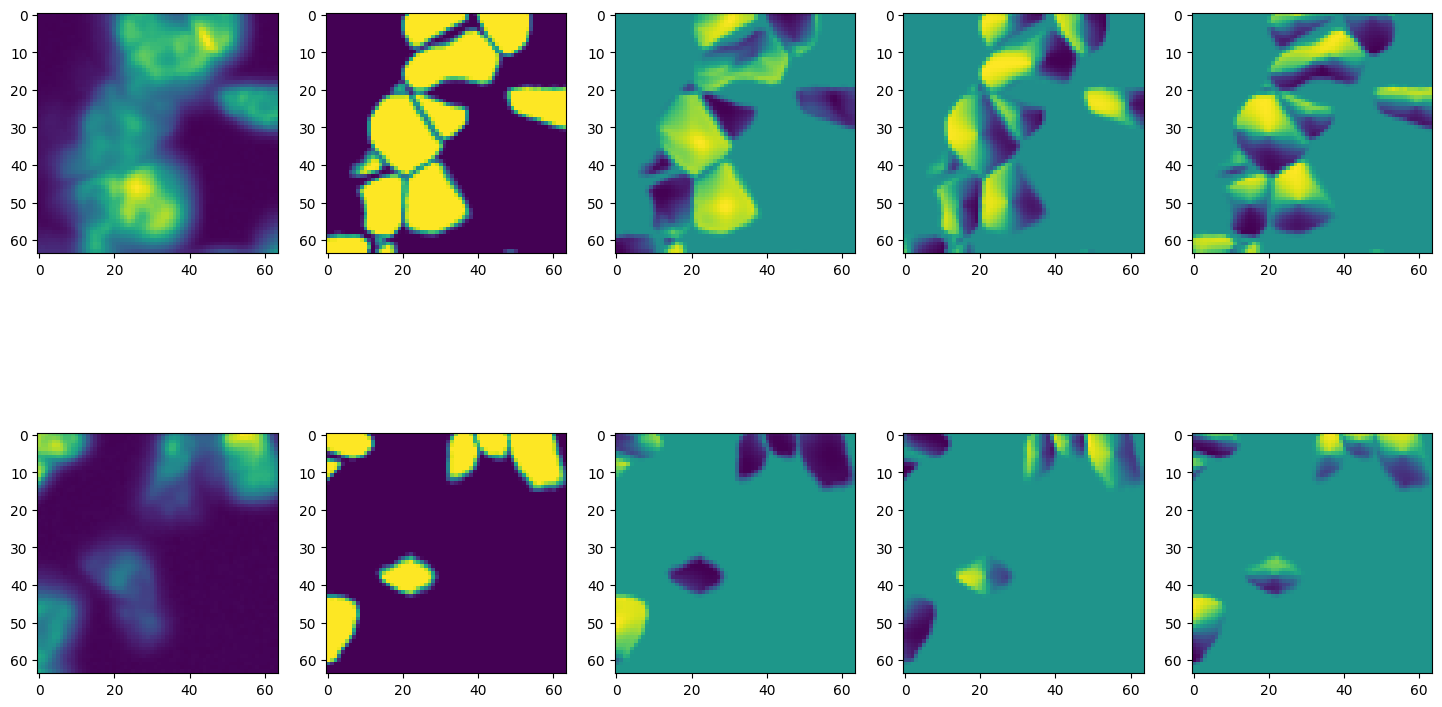

In [12]:
n_row = 2
fig, axes = plt.subplots(n_row, 5,sharex=False, sharey=False, figsize=(18,10))

slice2view = args.ROI[-1]//2
for i in range(n_row):
    datai = next(iter(train_loader))
    img2plot=datai['image']
    label2plot=datai['label']
    print(img2plot.shape, label2plot.shape)

    top= torch.max(img2plot[0,0,:,:,:],dim=-1)[0].detach().cpu()



    mask0= label2plot[0,0,:,:,slice2view].detach().cpu()
    mask1= label2plot[0,1,:,:,slice2view].detach().cpu()
    mask2= label2plot[0,2,:,:,slice2view].detach().cpu()
    mask3= label2plot[0,3,:,:,slice2view].detach().cpu()

    print(mask0.max(),mask0.min())
    print('mask2',mask2.max(),mask2.min())
    axes[i,0].imshow(img2plot[0,0,:,:,slice2view])

    
    axes[i,1].imshow(mask0)
    axes[i,2].imshow(mask1)
    axes[i,3].imshow(mask2)
    axes[i,4].imshow(mask3)



In [16]:
from monai.networks.nets import SwinUNETR
from swincell.utils.utils import AverageMeter
model = SwinUNETR(
            img_size=args.ROI,
            in_channels=1,
            out_channels=4,
            # feature_size=args.feature_size,
            feature_size=48,
            use_checkpoint=None,
        ).to(device)

from torch.nn import MSELoss,BCEWithLogitsLoss
from monai.losses import DiceLoss
loss1 = MSELoss(reduction='mean')
loss2 = DiceLoss(to_onehot_y=False, sigmoid=True)
# dice_loss2 = BCEWithLogitsLoss(reduction='mean')
losses = [loss1,loss2]

optimizer = torch.optim.SGD(
            model.parameters(), lr=args.optim_lr, momentum=0.99, nesterov=True, weight_decay=1e-5
        )
res =[]
alist= []
blist = []
# for epoch in range(args.max_epochs):
for epoch in range(10):
    model.train()
    run_loss = AverageMeter()
    for i, data in enumerate(train_loader):
        loss_func1 = losses[0]
        loss_func2 = losses[1]
        data, target = data['image'].to(device), data['label'].to(device)
        logits = model(data)
        # print(logits.shape,target.shape)
        #  weight_factor*flow loss     +      cell probability loss
        print(logits.shape,target.shape)
        a = loss_func1(logits[:,1:], target[:,1:])
        b= loss_func2(logits[:,0], target[:,0])
        print(a.item(),b.item())
        loss = 5*loss_func1(logits[:,1:], target[:,1:]) + loss_func2(logits[:,0], target[:,0])
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item())

        # run_loss.update(loss.item(), n=args.batch_size)
        # print(loss_func1.item(),loss_func2.item())
        res.append(loss.item())
        alist.append(a.item())
        blist.append(b.item())
        print('Epoch {}/{} {}/{}'.format(epoch, args.max_epochs, i, len(train_loader)), "loss: {:.4f}".format(run_loss.avg))

torch.Size([1, 4, 128, 128, 32]) torch.Size([1, 4, 128, 128, 32])
0.30483531951904297 0.6076904535293579
Epoch 0/5 0/24 loss: 2.1319
torch.Size([1, 4, 128, 128, 32]) torch.Size([1, 4, 128, 128, 32])
0.30945292115211487 0.6000286340713501
Epoch 0/5 1/24 loss: 2.1396
torch.Size([1, 4, 128, 128, 32]) torch.Size([1, 4, 128, 128, 32])
0.28659018874168396 0.6262463331222534
Epoch 0/5 2/24 loss: 2.1128
torch.Size([1, 4, 128, 128, 32]) torch.Size([1, 4, 128, 128, 32])
0.27972128987312317 0.6358232498168945
Epoch 0/5 3/24 loss: 2.0932
torch.Size([1, 4, 128, 128, 32]) torch.Size([1, 4, 128, 128, 32])
0.2445048987865448 0.6708791255950928
Epoch 0/5 4/24 loss: 2.0532
torch.Size([1, 4, 128, 128, 32]) torch.Size([1, 4, 128, 128, 32])
0.2180493324995041 0.6707120537757874
Epoch 0/5 5/24 loss: 2.0045
torch.Size([1, 4, 128, 128, 32]) torch.Size([1, 4, 128, 128, 32])
0.21133548021316528 0.6527997255325317
Epoch 0/5 6/24 loss: 1.9624
torch.Size([1, 4, 128, 128, 32]) torch.Size([1, 4, 128, 128, 32])
0.197

In [10]:
print(alist)

[0.33568015694618225, 0.21164686977863312, 0.28681865334510803, 0.335453063249588, 0.37680259346961975, 0.16040650010108948, 0.2362363338470459, 0.25681599974632263, 0.24236735701560974, 0.27125242352485657, 0.22259549796581268, 0.2459748089313507, 0.21839375793933868, 0.2539031207561493, 0.20341862738132477, 0.17079275846481323, 0.21699103713035583, 0.23521018028259277, 0.2275153249502182, 0.14627042412757874, 0.17859525978565216, 0.22714440524578094, 0.19551807641983032, 0.18262386322021484, 0.1641356647014618, 0.23711954057216644, 0.273205041885376, 0.20709694921970367, 0.2720131278038025, 0.28301021456718445, 0.23854827880859375, 0.17928536236286163, 0.23306699097156525, 0.2577389180660248, 0.2563512325286865, 0.1814219206571579, 0.21928083896636963, 0.19621743261814117, 0.20522354543209076, 0.20058812201023102, 0.1721038818359375, 0.22518062591552734, 0.14375007152557373, 0.20582939684391022, 0.1408870965242386, 0.169067844748497, 0.16763895750045776, 0.13512519001960754, 0.147821

In [2]:
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from functools import partial
# from monai.transforms import RemoveSmallObjects,FillHoles
# from monai.transforms import FillHoles
from monai.transforms import Activations, AsDiscrete, Compose,FillHoles
model_path = '/data/programs/monai_research_contributions/SwinUNETR/allen/runs/Nanolive_finetune3/foldNone/model_final.pt'
model = SwinUNETR(
    img_size=(96,96,96),
    in_channels=1,
    out_channels=1,
    feature_size=48,
    use_checkpoint=False,
).cuda(0)
model_dict = torch.load(model_path)["state_dict"]
model.load_state_dict(model_dict)


model_inferer = partial(
    sliding_window_inference,
    roi_size=(96,96,96),
    # roi_size=(128,128,96),

    sw_batch_size=2,
    predictor=model,
    overlap=0.5,
)
post_sigmoid = Activations(sigmoid=True)
# post_pred = AsDiscrete(argmax=False, logit_thresh=1.01)
post_pred = AsDiscrete(argmax=False, threshold=0.6)



# print(val_output_convert.shape)


In [3]:
post_trans = Compose([
    Activations(sigmoid=True),
    AsDiscrete(argmax=False, threshold=0.5),
    # RemoveSmallObjects(min_size = 100),
    FillHoles(applied_labels=None, connectivity=2)

])

with torch.no_grad():
        for idx, batch_data in enumerate(valid_loader):
            data_raw, target = batch_data["image"], batch_data["label"]
            data_raw, target = data_raw.cuda(0), target.cuda(0)
            # with autocast(enabled=True):
            logits = model_inferer(data_raw)
            # val_labels_list = decollate_batch(target)
            # val_outputs_list = decollate_batch(logits)
            print(logits.max(),logits.min())
            val_labels_list = target
            val_outputs_list = logits
            # val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            a = post_sigmoid(val_outputs_list)
            print('after sigmoid',a.max(),a.min(),a.median())
            val_output_convert1 = post_pred(post_sigmoid(val_outputs_list))
            val_output_convert2 = post_trans(logits)
            print(val_output_convert1.max(),val_output_convert1.min(),val_output_convert1.median())

tensor(268.0057, device='cuda:0') tensor(-16.6058, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(6.1402e-08, device='cuda:0') tensor(0.0005, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0')
tensor(268.0057, device='cuda:0') tensor(-16.6058, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(6.1402e-08, device='cuda:0') tensor(0.0005, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0')
tensor(232.3488, device='cuda:0') tensor(-15.7250, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(1.4816e-07, device='cuda:0') tensor(0.0005, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0')


# test inference

In [27]:
root_dir = '/data/download_data/quilt-data-access-tutorials-main/all_fov/'
df = pd.read_csv(root_dir+'meta_info.csv')

# input_dir=df['fov_path'].unique()[100:220].tolist()
# target_dir=df['fov_seg_path'].unique()[100:220].tolist()
# train_img_paths =input_dir[:100]
# train_label_paths = target_dir[:100]
# valid_img_paths =input_dir[100:]
# valid_label_paths = target_dir[100:]

input_dir=df['fov_path'].unique()[300:320].tolist()
# target_dir=df['fov_seg_path'].unique()[:20].tolist()
train_img_paths =input_dir[:20]



train_img_full_paths =[os.path.join(root_dir,'fov_path_channel/'+file.split('/')[-1]) for file in train_img_paths]





test_datalist = [{'image':a} for a in train_img_full_paths] 
test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.AddChanneld(keys=["image"]),
        transforms.Resized(keys=["image"],spatial_size=(512,512,96)),
        # transforms.ScaleIntensityRanged(
        #     keys=["image"], a_min=18000, a_max=26000, b_min=0, b_max=1, clip=True
        # ),
        transforms.ToTensord(keys=["image"]),
    ]
)

test_ds = data.Dataset(data=test_datalist, transform=test_transform)
test_loader = data.DataLoader(
        test_ds, batch_size=1, num_workers=24, sampler=None, drop_last=True
    )

Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.


In [28]:
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from functools import partial
# from monai.transforms import RemoveSmallObjects,FillHoles
# from monai.transforms import FillHoles
from monai.transforms import Activations, AsDiscrete, Compose,FillHoles
model_path = '/data/programs/monai_research_contributions/SwinUNETR/allen/runs/Nanolive_finetune3/foldNone/model_final.pt'
model = SwinUNETR(
    img_size=(96,96,96),
    in_channels=1,
    out_channels=1,
    feature_size=48,
    use_checkpoint=False,
).cuda(0)
model_dict = torch.load(model_path)["state_dict"]
model.load_state_dict(model_dict)


model_inferer = partial(
    sliding_window_inference,
    roi_size=(96,96,96),
    # roi_size=(128,128,96),

    sw_batch_size=2,
    predictor=model,
    overlap=0.5,
)
post_sigmoid = Activations(sigmoid=True)
# post_pred = AsDiscrete(argmax=False, logit_thresh=1.01)
post_pred = AsDiscrete(argmax=False, threshold=0.6)

In [31]:
post_trans = Compose([
    Activations(sigmoid=True),
    AsDiscrete(argmax=False, threshold=0.5),
    # RemoveSmallObjects(min_size = 100),
    FillHoles(applied_labels=None, connectivity=2)

])

with torch.no_grad():
        for idx, batch_data in enumerate(test_loader):
            data_test = batch_data["image"]
            data_test = data_test.cuda(0)
            # with autocast(enabled=True):
            logits = model_inferer(data_test)
            # val_labels_list = decollate_batch(target)
            # val_outputs_list = decollate_batch(logits)
            print(logits.max(),logits.min())

            test_outputs_list = logits
            # val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            a = post_sigmoid(test_outputs_list)
            print('after sigmoid',a.max(),a.min(),a.median())
            test_output_convert1 = post_pred(post_sigmoid(test_outputs_list))
            test_output_convert2 = post_trans(logits)
            # print(val_output_convert1.max(),val_output_convert1.min(),val_output_convert1.median())

tensor(107.0293, device='cuda:0') tensor(-12.1564, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(5.2544e-06, device='cuda:0') tensor(0.0052, device='cuda:0')
tensor(85.8323, device='cuda:0') tensor(-15.6975, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(1.5228e-07, device='cuda:0') tensor(0.0061, device='cuda:0')
tensor(49.4350, device='cuda:0') tensor(-14.2095, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(6.7435e-07, device='cuda:0') tensor(0.0054, device='cuda:0')
tensor(71.0185, device='cuda:0') tensor(-12.2007, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(5.0267e-06, device='cuda:0') tensor(0.0056, device='cuda:0')
tensor(49.4618, device='cuda:0') tensor(-12.0011, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(6.1371e-06, device='cuda:0') tensor(0.0057, device='cuda:0')
tensor(43.2879, device='cuda:0') tensor(-11.9350, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tenso

In [86]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()